In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import harmonypy as hm

from scSLAT.model import spatial_match, scanpy_workflow
from scSLAT.metrics import region_statistics
from scSLAT.viz import match_3D_multi, match_3D_celltype, hist

In [3]:
adata1 = sc.read_h5ad('../seqFISH_filer.h5ad')
adata2 = sc.read_h5ad('../Stereo_filer.h5ad')

In [4]:
# make a dataframe, colname is 'batch', colvalue is 'rna' or 'atac' according to the embd0 and embd1
meta = pd.DataFrame({'batch':['adata1']*adata1.shape[0]+['adata2']*adata2.shape[0]})

In [7]:
adata_all = adata1.concatenate(adata2)
adata_all = scanpy_workflow(adata_all)
harm = hm.run_harmony(adata_all.obsm['X_pca'], adata_all.obs, 'batch', max_iter_harmony=20)
Z = harm.Z_corr.T

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
2023-02-02 00:39:03,578 - harmonypy - INFO - Iteration 1 of 20
2023-02-02 00:39:08,476 - harmonypy - INFO - Iteration 2 of 20
2023-02-02 00:39:13,241 - harmonypy - INFO - Converged after 2 iterations


In [9]:
embd0 = Z[:adata1.shape[0],:]
embd1 = Z[adata1.shape[0]:,:]

In [10]:
best, index, distance = spatial_match([embd0, embd1])

In [21]:
adata1_df = pd.DataFrame({'index':range(adata1.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'celltype':adata1.obs['celltype_mapped_refined']})

adata2_df = pd.DataFrame({'index':range(adata2.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype':adata2.obs['annotation']})

matching = np.array([range(best.shape[0]), best])
best_match = distance[:,0]
region_statistics(distance[:,0])

0.500~0.550       276          5.486%
0.550~0.600       507         10.078%
0.600~0.650       748         14.868%
0.650~0.700       887         17.631%
0.700~0.750       981         19.499%
0.750~0.800       815         16.200%
0.800~0.850       576         11.449%
0.850~0.900       180          3.578%
0.900~0.950        19          0.378%
0.950~1.000         0          0.000%


/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:204: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 21 cell types; dataset2: 11 cell types; 
                    Total :29 celltypes; Overlap: 3 cell types 
                    Not overlap :[['Allantois', 'Cranial mesoderm', 'Blood progenitors', 'Forebrain/Midbrain/Hindbrain', 'ExE endoderm', 'Splanchnic mesoderm', 'Surface ectoderm', 'Intermediate mesoderm', 'Mixed mesenchymal mesoderm', 'Presomitic mesoderm', 'Definitive endoderm', 'Haematoendothelial progenitors', 'Anterior somitic tissues', 'NMP', 'Erythroid', 'Cardiomyocytes', 'Lateral plate mesoderm', 'Endothelium', 'Heart', 'Liver', 'Branchial arch', 'Mesenchyme', 'Notochord', 'Connective tissue', 'AGM', 'Brain']]
Subsample 300 cell pairs from 5031


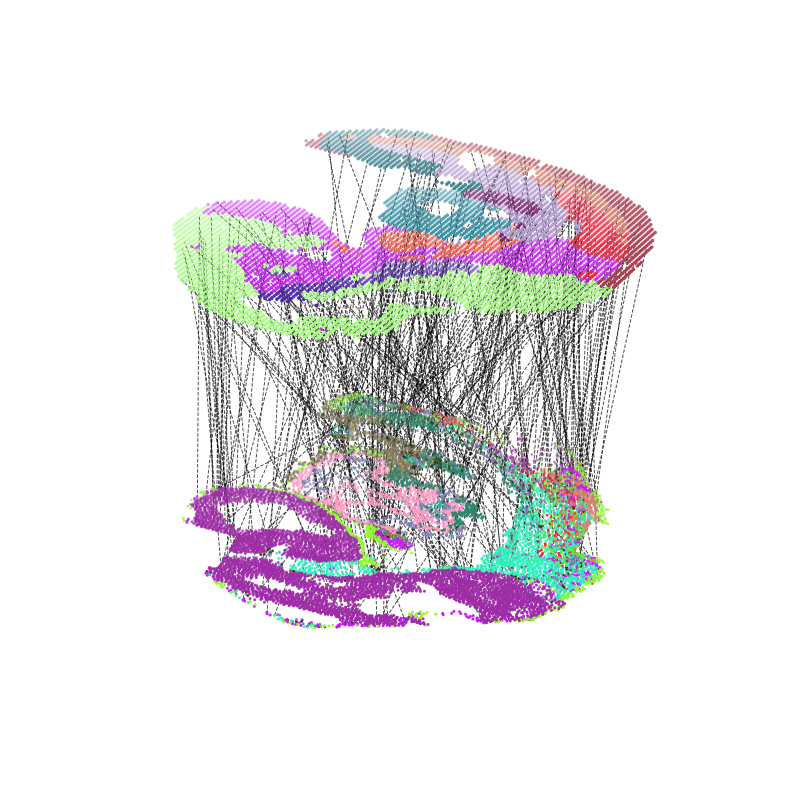

In [25]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)

multi_align.draw_3D(size=[10, 12], line_width=0.7, line_color='black', point_size=[1.25,2.5], 
                    hide_axis=True, show_error=False)

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:204: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 21 cell types; dataset2: 11 cell types; 
                    Total :29 celltypes; Overlap: 3 cell types 
                    Not overlap :[['Allantois', 'Cranial mesoderm', 'Blood progenitors', 'Forebrain/Midbrain/Hindbrain', 'ExE endoderm', 'Splanchnic mesoderm', 'Surface ectoderm', 'Intermediate mesoderm', 'Mixed mesenchymal mesoderm', 'Presomitic mesoderm', 'Definitive endoderm', 'Haematoendothelial progenitors', 'Anterior somitic tissues', 'NMP', 'Erythroid', 'Cardiomyocytes', 'Lateral plate mesoderm', 'Endothelium', 'Heart', 'Liver', 'Branchial arch', 'Mesenchyme', 'Notochord', 'Connective tissue', 'AGM', 'Brain']]
Subsample 2571 cell pairs from 2571


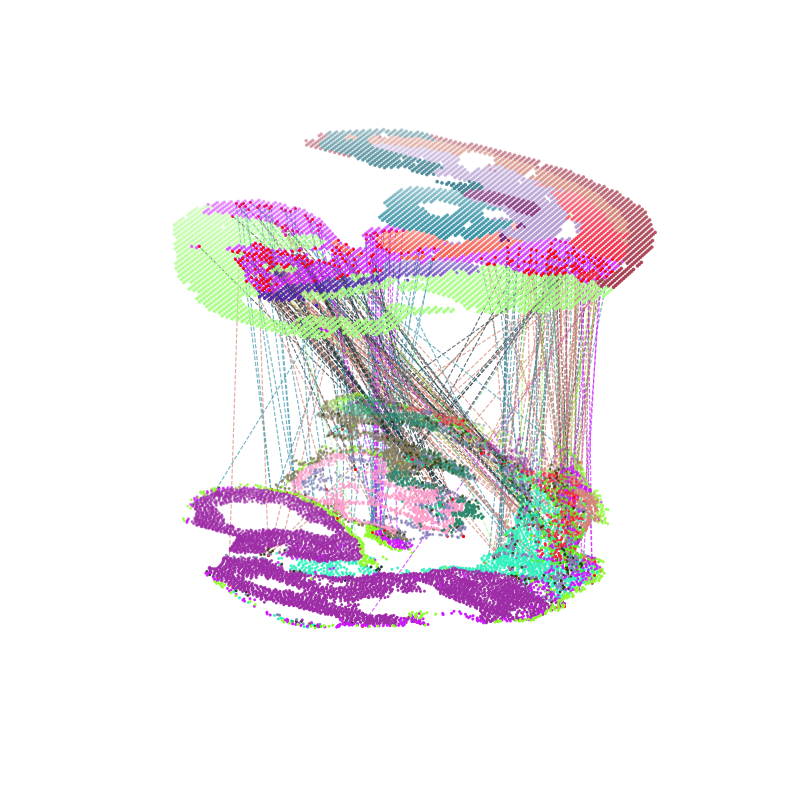

In [23]:
test = match_3D_celltype(adata1_df, adata2_df, matching[:, best_match > 0.7], meta='celltype', highlight_celltype=[list(set(adata1_df.celltype)),['Neural crest']],
                         subsample_size=3000, highlight_cell=['red'], scale_coordinate=True)
test.draw_3D(size=[10, 12], line_width=0.8, point_size=[1.25,2.5], hide_axis=True)